In [1]:
import sys
sys.path.append('..')
import os
os.chdir('..')
import numpy as np
import torch
import torchaudio
import os.path
from util.arg_extractor import extract_args_from_json
from experiment_builders.vqvae_builder import VQVAERawExperimentBuilder
from experiment_builders.vae_builder import VAERawExperimentBuilder
from models.common_networks import QuantisedInputModuleWrapper
from models.vqvae import VQVAE
from models.vae import VAE
from datasets.vcc_raw_dataset import VCCRawDataset
from datasets.vctk_dataset import VCTKDataset
from datasets.vctk_preprocessor import read_audio as read_audio_vctk
import util.torchaudio_transforms as transforms
import librosa.display
import matplotlib.pyplot as plt
import math
torch.set_printoptions(profile="full")

In [42]:
args = extract_args_from_json('experiment_configs/vae_vcc_raw.json')
args.continue_from_epoch = 0
args.eval_out_path='audio_out'
args.eval_audio_path = 'data/vcc2016_training/SF1/100001.wav' 

In [43]:
# Load audio
audio_path = os.path.expanduser(args.eval_audio_path)
torchaudio.initialize_sox()
audio, sr = read_audio_vctk(audio_path, downsample=True, trim_silence=True)
torchaudio.shutdown_sox()
print(audio.shape)

torch.Size([1, 48829])


[ 0.03265381  0.03564453  0.03857422 ...  0.00881958  0.01223755
 -0.01965332]
torch.Size([1, 1, 48829])
torch.Size([5, 1, 8192])


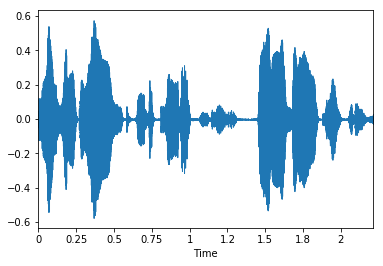

In [44]:
audio = audio.unsqueeze(0)
audio_plain = audio.numpy()[0, 0]
print(audio_plain)
plt.figure()
librosa.display.waveplot(audio_plain)
print(audio.shape)
audio_split = audio[:, :, :audio.shape[-1] - (audio.shape[-1] % args.input_len)]
audio_split = audio_split.view(int(audio.shape[-1] / args.input_len), 1, args.input_len)
print(audio_split.shape)

## VQVAE

In [33]:
mulaw = transforms.MuLawEncoding(quantization_channels=args.num_input_quantization_channels)
mulaw_expanding = transforms.MuLawExpanding(quantization_channels=args.num_input_quantization_channels)

# Prepare model
vqvae_model = VQVAE(
    input_shape=(1, 1, args.input_len),
    encoder_arch=args.encoder,
    vq_arch=args.vq,
    generator_arch=args.generator,
    num_speakers=args.num_speakers,
    speaker_dim=args.speaker_dim,
    use_gated_convolutions=args.use_gated_convolutions)

# Select epoch
epoch = 76

# Load model from state
quantised_input_vqvae_model = QuantisedInputModuleWrapper(args.num_input_quantization_channels, vqvae_model)
    
vqvae_experiment = VQVAERawExperimentBuilder(network_model=quantised_input_vqvae_model,
                                    experiment_name=args.experiment_name,
                                    weight_decay_coefficient=args.weight_decay_coefficient,
                                    learning_rate=args.learning_rate,
                                    commit_coefficient=args.commit_coefficient,
                                    device=torch.device('cpu'),
                                    continue_from_epoch=epoch,
                                    train_data=None,
                                    val_data=None,
                                    num_epochs=None)

Building VQVAE.
Building Encoder with 6 downsampling layers.
torch.Size([1, 1, 8192])
torch.Size([1, 32, 2731])
torch.Size([1, 32, 2731])
torch.Size([1, 64, 911])
torch.Size([1, 64, 911])
torch.Size([1, 128, 304])
torch.Size([1, 64, 304])
Building VQ layer.
VQ latent shape: torch.Size([1, 64, 304])
speaker_out shape: torch.Size([1, 64, 304])
Building Decoder/Generator with 7 upsampling layers.
torch.Size([1, 64, 304])
torch.Size([1, 32, 912])
torch.Size([1, 32, 912])
torch.Size([1, 16, 2736])
torch.Size([1, 16, 2736])
torch.Size([1, 16, 8192])
torch.Size([1, 16, 8192])
torch.Size([1, 256, 8192])
Building Quantised input module.
/home/vaidas/Projects/mlpcw/experiments/vqvae_vcc_raw /home/vaidas/Projects/mlpcw/experiments/vqvae_vcc_raw/result_outputs
Loading model train_model, at epoch 76.


In [34]:
args.eval_speaker_id = 5
# Prepare speaker tensor
speaker_id = torch.tensor(args.eval_speaker_id, dtype=torch.long)

In [38]:
out_mulaw = vqvae_experiment.convert(x=mulaw(audio_split), y=speaker_id)

out = mulaw_expanding(out_mulaw).detach()
print(out.shape)
out = out.view(1, -1)

torch.Size([5, 8192])


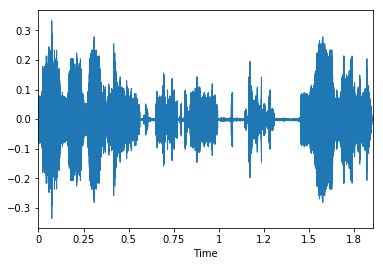

In [39]:
plt.figure()
librosa.display.waveplot(out[0].numpy())

In [41]:
out_path = os.path.expanduser(args.eval_out_path)
out_filename = 'vqvae_{}_{}_{}.wav'.format(os.path.basename(args.eval_audio_path).split('.')[0], args.eval_speaker_id, epoch)
out_file_path = os.path.join(out_path, out_filename)

# Save as audio
torchaudio.save(filepath=out_file_path, src=out, sample_rate=sr)

## VAE

In [ ]:
# sample_len = args.input_max_len
# audio_trimmed = audio
# if audio.shape[-1] % sample_len > 0:
#     # Cut the end of the sample if its too long to be equally split.
#     audio_trimmed = audio[:,:, :audio.shape[-1] -(audio.shape[-1] % sample_len)]
# audio_splits = audio_trimmed.squeeze(0).view(-1, sample_len).unsqueeze(1)
# print(audio_splits.shape)

In [45]:
vae_model = VAE(
    input_shape=(1, 1, args.input_len),
    encoder_arch=args.encoder,
    generator_arch=args.generator,
    latent_dim=args.latent_dim,
    num_speakers=args.num_speakers,
    speaker_dim=args.speaker_dim,
    use_gated_convolutions=args.use_gated_convolutions)

# Select epoch
epoch = 48

# Load model from state
quantised_input_vae_model = QuantisedInputModuleWrapper(args.num_input_quantization_channels, vae_model)

vae_experiment = VAERawExperimentBuilder(network_model=quantised_input_vae_model,
                                    experiment_name=args.experiment_name,
                                    num_epochs=args.num_epochs,
                                    weight_decay_coefficient=args.weight_decay_coefficient,
                                    learning_rate=args.learning_rate,
                                    device=torch.device('cpu'),
                                    continue_from_epoch=epoch,
                                    train_data=None,
                                    val_data=None)

Building VAE.
Building Encoder with 6 downsampling layers.
torch.Size([1, 1, 8192])
torch.Size([1, 32, 2731])
torch.Size([1, 32, 2731])
torch.Size([1, 64, 911])
torch.Size([1, 64, 911])
torch.Size([1, 128, 304])
torch.Size([1, 64, 304])
mean shape: torch.Size([1, 256])
logvar shape: torch.Size([1, 256])
latent shape: torch.Size([1, 256])
latent_out shape: torch.Size([1, 19456])
speaker_out shape: torch.Size([1, 19456])
latent_out reshaped: torch.Size([1, 64, 304])
Building Decoder/Generator with 7 upsampling layers.
torch.Size([1, 64, 304])
torch.Size([1, 32, 912])
torch.Size([1, 32, 912])
torch.Size([1, 16, 2736])
torch.Size([1, 16, 2736])
torch.Size([1, 16, 8192])
torch.Size([1, 16, 8192])
torch.Size([1, 256, 8192])
Building Quantised input module.
/home/vaidas/Projects/mlpcw/experiments/vae_vcc_raw /home/vaidas/Projects/mlpcw/experiments/vae_vcc_raw/result_outputs
Loading model train_model, at epoch 48.


In [46]:
args.eval_speaker_id = 5
# Prepare speaker tensor
speaker_id = torch.tensor(args.eval_speaker_id, dtype=torch.long)

In [49]:
out_mulaw = vae_experiment.convert(x=mulaw(audio_split), y=speaker_id)

out = mulaw_expanding(out_mulaw).detach()
print(out.shape)
out = out.view(1, -1)

torch.Size([5, 8192])


In [ ]:
plt.figure()
librosa.display.waveplot(out[0].numpy())

In [ ]:
out_path = os.path.expanduser(args.eval_out_path)
out_filename = 'vae_{}_{}_{}.wav'.format(os.path.basename(args.eval_audio_path).split('.')[0], args.eval_speaker_id, epoch)
out_file_path = os.path.join(out_path, out_filename)

# Save as audio
torchaudio.save(filepath=out_file_path, src=out, sample_rate=sr)